In [30]:
from firedrake import *
from firedrake.petsc import PETSc
import os
from firedrake.__future__ import interpolate
from firedrake.output import VTKFile

printpar = PETSc.Sys.Print        # print once even in parallel

def generate_mesh(xt,yt):
    
    # generate a geo file and mesh for a surface given by (xt,yt)
    
    fd = open('channel.geo', 'w', newline="")
    fd.write('lc = 50;\n')
    Np = len(xt)
    
    for k in range(Np):
       line = 'Point(' + str(k+1) + ') = {' + str(xt[k]) + ',' + str(yt[k]) + ',0,lc};\n'
       fd.write(line)
       
    Np += 1
    fd.write('lc_ch = 10;\n')
    fd.write('Point(' + str(Np) +') = {1000.0,-270.0,0,lc};\n')
    fd.write('Point(' + str(Np+1) + ') = {600.0,-270.0,0,lc_ch};\n')
    fd.write('Point(' + str(Np+2) + ') = {550.0,-250.0,0,lc_ch};\n')
    fd.write('Point(' + str(Np+3) + ') = {500.0,-270.0,0,lc_ch};\n')
    fd.write('Point(' + str(Np+4) + ') = {0.0,-270.0,0,lc};\n')
    
    line = 'Line(50) = {'
    for k in range(Np-1):
       line += str(k+1) + ','
    line = line[:-1] + '};\n'
    fd.write(line)
    
    fd.write('Line(51) = {' + str(Np-1) + ',' + str(Np) + '};\n')
    fd.write('Line(52) = {' + str(Np) + ',' + str(Np+1) + '};\n')
    fd.write('Spline(53) = {' + str(Np+1) + ',' + str(Np+2) + ',' + str(Np+3) + '};\n')
    fd.write('Line(54) = {' + str(Np+3) + ',' + str(Np+4) + '};\n')
    fd.write('Line(55) = {' + str(Np+4) + ',1};\n')

    fd.write('Line Loop(56) = {50,51,52,53,54,55};\n')
    
    fd.write('Plane Surface(61) = {56};\n')
    
    fd.write('Physical Line(71) = {50};\n') #surface
    fd.write('Physical Line(72) = {51};\n') #right side
    fd.write('Physical Line(73) = {52,53,54};\n') #bottom
    fd.write('Physical Line(74) = {55};\n') #left
    
    fd.write('Physical Surface(81) = {61};\n')   # if Physical Surface omitted, Gmsh fails
    
    fd.close()
    
    os.system('gmsh -2 channel.geo')

    
xt = np.linspace(0,1000,41)
yt = 30*np.ones_like(xt)

dt = 1
t_end = 2

secpera = 31556926.0    # seconds per year
g = 9.81                # m s-2
rho = 900.0             # kg m-3
rhow = 1000.0
n_glen = 3.0
A3 = 3.1689e-24         # Pa-3 s-1;  EISMINT I value of ice softness
B3 = A3**(-1.0/n_glen)     # Pa s(1/3);  ice hardness
eps = .01
Dtyp = 1.0 / secpera    # s-1

    
def D(w):               # strain-rate tensor
    return 0.5 * (grad(w) + grad(w).T)

fbody = Constant((0.0, - rho * g))

t = 0.0


myResults = VTKFile('channel.pvd')
while t<t_end:

    
    generate_mesh(xt,yt)
    
    printpar = PETSc.Sys.Print        # print once even in parallel
    printpar('reading mesh from channel.msh ...')
    mesh = Mesh('channel.msh')
    printpar('    (mesh with %d elements and %d vertices)' \
         % (mesh.num_cells(), mesh.num_vertices()))
    
    V = VectorFunctionSpace(mesh, 'Lagrange', 2)
    W = FunctionSpace(mesh, 'Lagrange', 1)
    Z = V * W
    
    up = Function(Z)
    u, p = split(up)
    v, q = TestFunctions(Z)
    
    # Get the coordinates of all the nodes in the quadratic space.
    x,y = SpatialCoordinate(mesh)
    
    Du2 = 0.5 * inner(D(u), D(u)) + (eps * Dtyp)**2.0
    nu = 0.5 * B3 * Du2**((1.0 / n_glen - 1.0)/2.0)
    
    pw = Function(W).interpolate(rhow*g*y)
    n = FacetNormal(mesh)
    
    F = ( inner(2.0 * nu * D(u), D(v)) \
      - p * div(v) - q * div(u) - inner(fbody, v) ) * dx \
      - pw * inner(n,v) * ds(73)
      
    bcs = [ DirichletBC(Z.sub(0), Constant((0.0, 0.0)), (72,74)) ]
    
    printpar('solving t = ' + str(t) + '....')
    par = {'snes_linesearch_type': 'bt',
       'ksp_type': 'preonly',
       'pc_type': 'lu',
       'pc_factor_shift_type': 'inblocks',
       'snes_max_it': 200}
#       'snes_atol': 1e2}

    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    u,p = split(up)
    eps /= 10
    solve(F == 0, up, bcs=bcs, options_prefix='s', solver_parameters=par)
    
    # print average and maximum velocity
    P1 = FunctionSpace(mesh, 'CG', 1)
    one = Function(W).interpolate(1.0)
    area = assemble(dot(one,one) * dx)
    umagav = assemble(sqrt(dot(u, u)) * dx) / area
    umag = assemble(interpolate(sqrt(dot(u, u)), P1))
    with umag.dat.vec_ro as vumag:
        umagmax = vumag.max()[1]
    printpar('  ice speed (m a-1): av = %.3f, max = %.3f' \
         % (umagav * secpera, umagmax * secpera))

    printpar('saving to channel' + str(k) + '.pvd ...')
    u = up.subfunctions[0]
    p = up.subfunctions[1]
    P1 = FunctionSpace(mesh, 'CG', 1)
    Du = sqrt(0.5 * inner(D(u), D(u)))
    eff_strain = assemble(interpolate(Du*secpera, P1))
    eff_strain.rename('effective strain rate')
    u *= secpera    # save in m/a
    p /= 1.0e5      # save in bar
    u.rename('velocity (m/a)')
    p.rename('pressure (bar)')
    myResults.write(u, p, eff_strain, time=t)
    
    # updating the surface by remeshing
    bound_points = [[xt[i], yt[i]] for i in range(np.size(xt))]
    f = Function(V).interpolate(u)
    u_bound=f.at(bound_points)
    
    ux = np.array([u_bound[i][0] for i in range(len(u_bound))])
    uy = np.array([u_bound[i][1] for i in range(len(u_bound))])
    
    xt += ux*dt
    yt += uy*dt

    # mesh update 

    # displaced_coordinates = interpolate(SpatialCoordinate(mesh) + u*dt, V)
    # mesh = Mesh(displaced_coordinates)
    
    t += dt


Info    : Running 'gmsh -2 channel.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Thu Jun  6 21:30:42 2024
Info    : Reading 'channel.geo'...
Info    : Done reading 'channel.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 50 (Line)
Info    : [ 20%] Meshing curve 51 (Line)
Info    : [ 40%] Meshing curve 52 (Line)
Info    : [ 50%] Meshing curve 53 (Nurb)
Info    : [ 70%] Meshing curve 54 (Line)
Info    : [ 90%] Meshing curve 55 (Line)
Info    : Done meshing 1D (Wall 0.00577732s, CPU 0.005777s)
Info    : Meshing 2D...
Info    : Meshing surface 61 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00876307s, CPU 0.008761s)
Info    : 444 nodes 852 elements
Info    : Writing 'channel.msh'...
Info    : Done writing 'channel.msh'
Info    : Stopped on Thu Jun  6 21:30:42 2024 (From start: Wall 0.0173827s, CPU 0.04635s)
reading mesh from channel.msh ...
    (mesh with 725 elements and 404 vertices)
solving t = 0.0....
  ice speed (m a-1): av = 0.341, max = 0.7

ConvergenceError: Nonlinear solve failed to converge after 125 nonlinear iterations.
Reason:
   DIVERGED_LINE_SEARCH

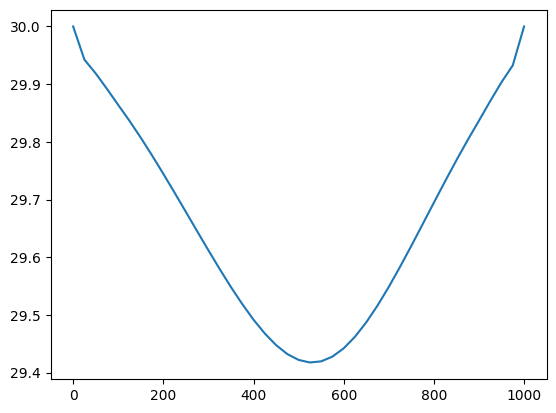

In [31]:
from matplotlib import pyplot as plt
plt.plot(xt,yt)

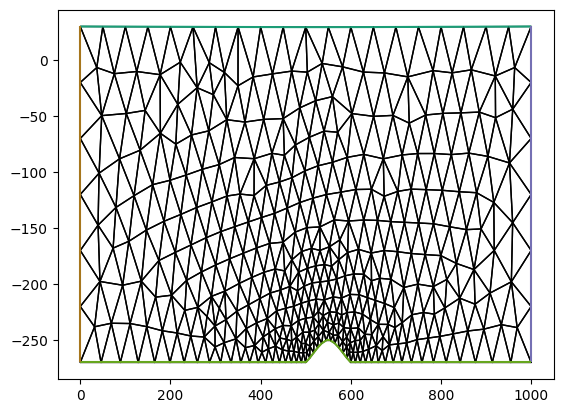

In [32]:
triplot(mesh)